## 1. libraries import and setup

In [1]:
import geopandas as gpd
import rioxarray as rxr
from rioxarray.merge import merge_datasets
import numpy as np
from matplotlib import pyplot as plt
import rasterio
from rasterio.features import rasterize
from rasterio.enums import Resampling
from scipy.ndimage import generic_filter
from scipy.interpolate import griddata
from pathlib import Path
import importlib.util

In [2]:
# load the setup.py module
path = Path.cwd().parent / 'src' / 'setup.py'
spec = importlib.util.spec_from_file_location('setup', path)
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

# call the make_folders function
raw_data_dir, processed_data_dir, output_dir = setup.make_folders()

created directory data\raw_data\DOPs
created directory data\raw_data\laz_ALS
created directory data\raw_data\laz_DAP
created directory data\raw_data\dtm_tiles
created directory data\raw_data\test_tiles
created directory data\processed_data\DOPs
created directory data\processed_data\nDSMs_ALS
created directory data\processed_data\nDSMs_DAP
created directory data\processed_data\laz_ALS
created directory data\processed_data\laz_DAP
created directory data\processed_data\datasets
created directory data\processed_data\models
created directory data\processed_data\gap_polygons_ALS
created directory data\processed_data\gap_polygons_DAP
created directory data\metadata
created directory src
created directory scripts
created directory output


## 2. data reading and preprocessing

### 2.1 TDOPs
True digital orthophotos (TDOP) are used here. The TDOPs come in a spatial resolution of 0.07 m. Therefore, they must be resampled to the resolution of the normalized digitial surface models (nDSM) (0.5 m). Additionally, the bands of the TDOPs are normalized to range 0-255, and also converted from uint16 to uint8. The individual TDOPs are merged into one large TDOP. A small stripe with 255 values is computed after merging. This stripe is interpolated.

In [19]:
# define path to raw DOPs and to the 
# processed merged and downsampled DOP
dop_solling_path = raw_data_dir / 'DOPs'
dop_train_merged_file = processed_data_dir / 'DOPs' / 'dop_train_merged_downsampled.tif'

# list of DOP raster file names
dop_files = [
    'dop_train_544500_5727750.tif',
    'dop_train_544500_5729500.tif',
    'dop_train_544500_5731250.tif',
    'dop_train_546250_5727750.tif',
    'dop_train_546250_5729500.tif',
    'dop_train_546250_5731250.tif'
]

# define downsampling function
def downsample_dop(dataset, target_resolution):
    """Downsample DOPs to a given resolution."""
    # reproject DOP to the new resolution
    downsampled_dataset = dataset.rio.reproject(
        dataset.rio.crs,
        resolution=target_resolution,
        resampling=Resampling.bilinear,
        nodata=None
    )
    
    return downsampled_dataset

# define normalization and conversion function
def normalize_and_convert_to_uint8(dataset):
    """Normalize each band of the DOPs and convert to uint8."""
    for band in dataset:
        # get maximum value of each band
        max_value = dataset[band].max()
        
        # normalize the band to range 0-255
        dataset[band] = (dataset[band] / max_value) * 255
        
        # convert to uint8
        dataset[band] = dataset[band].astype('uint8')
    
    return dataset

# define interpolation function
def interpolate_255_stripe(dataset):
    """Interpolate over areas where pixel values are 255."""
    for band in dataset:
        band_data = dataset[band].values
        
        # convert data to float32 to handle NaN values
        band_data = band_data.astype(np.float32)
        
        # set 255 values to NaN for interpolation
        band_data[band_data == 255] = np.nan
        
        # interpolate NaN values using nearest neighbor approach
        band_data = generic_filter(
            band_data,
            function=np.nanmean,
            size=3,
            mode='nearest'
        )
        
        # convert back to uint8 after interpolation
        band_data = np.nan_to_num(band_data, nan=255).astype(np.uint8)
        
        # replace band values with the interpolated data
        dataset[band].values = band_data
        
    return dataset

# check if merged downsampled DOP already exists
if not dop_train_merged_file.exists():
    
    # read and downsample all DOP files
    downsampled_dops = []
    
    for dop_file in dop_files:
        
        dop = rxr.open_rasterio(dop_solling_path / dop_file, band_as_variable=True)
        
        # assign CRS (EPSG:25832)
        dop = dop.rio.write_crs('epsg:25832', inplace=True)
        
        # downsample DOP
        print(f'downsampling {dop_file}...')
        dop_downsampled = downsample_dop(dop, target_resolution=0.5)
        
        # normalize and convert to uint8
        print(f'normalizing and converting {dop_file} to uint8...')
        dop_downsampled = normalize_and_convert_to_uint8(dop_downsampled)
        
        downsampled_dops.append(dop_downsampled)
    
    # merge downsampled DOPs
    print('merging downsampled DOPs...')
    dop_train_merged = rxr.merge.merge_datasets(downsampled_dops)
    
    # interpolate 255 values (small stripe)
    print('interpolating 255 stripe values...')
    dop_train_merged = interpolate_255_stripe(dop_train_merged)
    
    # save merged downsampled DOP
    dop_train_merged.rio.to_raster(dop_train_merged_file)
    print('Merged and downsampled DOP successfully saved.')

else:
    
    # read existing merged downsampled DOP
    dop_train_merged = rxr.open_rasterio(dop_train_merged_file, band_as_variable=True)
    print('Existing merged and downsampled DOP loaded.')

Existing merged and downsampled DOP loaded.


### 2.2 nDSMs/CHMs

For training, image-based (stereoscopic) nDSMs (also referred to as canopy height model (CHM)) are used. They were calculated with a spatial resolution of 0.5 m, and based on point clouds which were computed in different quality levels (pyramid level 2, 1, and 0). According to the quality levels, three nDSMs are used here. They are merged and clipped to the extent of the prior merged TDOP.

In [20]:
# define path to processed image-based nDSMs and to the 
# processed merged and clipped nDSM
ndsm_solling_path = processed_data_dir / 'nDSMs_DAP'
ndsm_train_merged_clipped_file = processed_data_dir / 'nDSMs_DAP' / 'ndsm_train_merged_clipped.tif'

# list of nDSM raster file names
ndsm_files = [
    'ndsm_solling_train_area_lev0.tif',
    'ndsm_solling_train_area_lev1.tif',
    'ndsm_solling_train_area_lev2.tif'
]

# define function to interpolate missing values
def interpolate_nan(array):
    x, y = np.indices(array.shape)
    non_nan_elements = ~np.isnan(array)
    
    # coordinates and values of non-NaN elements
    known_x = x[non_nan_elements]
    known_y = y[non_nan_elements]
    known_values = array[non_nan_elements]
    
    # coordinates of NaN elements
    missing_x = x[np.isnan(array)]
    missing_y = y[np.isnan(array)]
    
    # interpolate and fill NaNs
    array[np.isnan(array)] = griddata(
        (known_x, known_y), known_values, (missing_x, missing_y), method='nearest'
    )
    
    return array

# check if merged clipped nDSM already exists
if not ndsm_train_merged_clipped_file.exists():
    
    # read all nDSM files
    ndsms = []
    
    for ndsm_file in ndsm_files:
        
        ndsm = rxr.open_rasterio(ndsm_solling_path / ndsm_file, band_as_variable=True)
        
        # assign CRS (EPSG:25832)
        ndsm = ndsm.rio.write_crs('epsg:25832', inplace=True)
        
        ndsms.append(ndsm)
    
    # merge nDSMs
    print('merging nDSMs...')
    ndsm_train_merged = rxr.merge.merge_datasets(ndsms)

    # get bounding box of the merged DOP
    bounds_dop_train = dop_train_merged.rio.bounds()

    # clip merged nDSM to the extent of the merged DOP
    print('clipping nDSM...')
    ndsm_train_merged_clipped = ndsm_train_merged.rio.clip_box(*bounds_dop_train)
    
    # interpolate NaN values
    print('interpolating NaN values...')
    ndsm_train_merged_clipped['band_1'].values = interpolate_nan(ndsm_train_merged_clipped['band_1'].values)
    
    # save merged clipped nDSM
    ndsm_train_merged_clipped.rio.to_raster(ndsm_train_merged_clipped_file)
    print('Merged, clipped, and interpolated nDSM successfully saved.')

else:

    # read existing merged clipped nDSM
    ndsm_train_merged_clipped = rxr.open_rasterio(ndsm_train_merged_clipped_file, band_as_variable=True)
    print('Existing merged and clipped nDSM loaded.')

Existing merged and clipped nDSM loaded.


### 2.3 gap polygons
Gap polygons were previously generated automatically from an ALS-based CHM. See script "gap_generation.R".

       gap_id                                           geometry
0           1  POLYGON ((544517.500 5727819.500, 544518.000 5...
1           2  POLYGON ((544511.000 5728032.500, 544511.000 5...
2           3  POLYGON ((544505.000 5728043.500, 544505.000 5...
3           4  POLYGON ((544513.000 5728481.000, 544513.000 5...
4           5  POLYGON ((544514.000 5728482.000, 544514.500 5...
...       ...                                                ...
15680   15681  POLYGON ((547965.000 5732887.000, 547965.000 5...
15681   15682  POLYGON ((547992.000 5732887.500, 547992.000 5...
15682   15683  POLYGON ((547993.500 5732894.500, 547993.000 5...
15683   15684  POLYGON ((547933.500 5732923.500, 547933.500 5...
15684   15685  POLYGON ((547996.000 5732915.500, 547996.000 5...

[15685 rows x 2 columns]


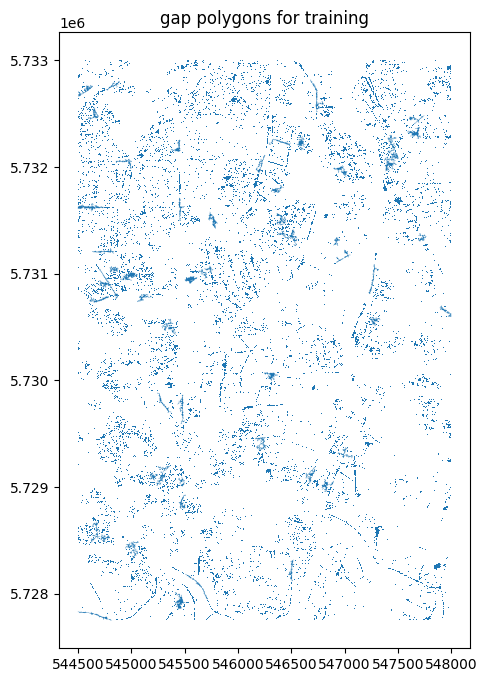

In [6]:
# read gap polygons
gap_polys_path = processed_data_dir / 'gap_polygons_ALS'

gap_polys_train = gpd.read_file(gap_polys_path / 'gap_polys_train.gpkg')

print(gap_polys_train)

# quick overview of the gap polygons
fig, ax = plt.subplots(figsize=(14,8))
gap_polys_train.plot(ax=ax)
ax.set_title('gap polygons for training')
plt.show()

## 3. creation of one dataset
### 3.1 merge nDSM and DOP into one dataset

In [9]:
# reproject TDOP to match the grid and resolution of the nDSM
dop_train = dop_train_merged.rio.reproject_match(ndsm_train_merged_clipped)

# make copy of the TDOP dataset
dop_train_copy = dop_train.copy()

# add the nDSM as new variable to the TDOP dataset
dop_train_copy['ndsm'] = (['y', 'x'], ndsm_train_merged_clipped['band_1'].values)

# copy the attributes from the nDSM band
dop_train_copy['ndsm'].attrs = ndsm_train_merged_clipped['band_1'].attrs

# convert spectral bands to float32 and ensure equal NoData values
for band in dop_train_copy.data_vars:
    dop_train_copy[band] = dop_train_copy[band].astype('float32')
    dop_train_copy[band].rio.write_nodata(np.nan, inplace=True)

# rename the dataset
train_ds = dop_train_copy
print(train_ds)

<xarray.Dataset>
Dimensions:      (x: 7000, y: 10501)
Coordinates:
  * x            (x) float64 5.445e+05 5.445e+05 5.445e+05 ... 5.48e+05 5.48e+05
  * y            (y) float64 5.733e+06 5.733e+06 ... 5.728e+06 5.728e+06
    spatial_ref  int32 0
Data variables:
    band_1       (y, x) float32 53.0 53.0 58.0 63.0 64.0 ... 64.0 55.0 54.0 55.0
    band_2       (y, x) float32 58.0 58.0 61.0 63.0 63.0 ... 71.0 62.0 61.0 62.0
    band_3       (y, x) float32 56.0 55.0 57.0 58.0 59.0 ... 65.0 60.0 59.0 60.0
    band_4       (y, x) float32 97.0 96.0 97.0 93.0 ... 113.0 104.0 103.0 105.0
    ndsm         (y, x) float32 24.06 24.03 17.49 22.11 ... 17.21 17.09 13.66
Attributes:
    AREA_OR_POINT:  Area


### 3.2 add canopy gaps as raster mask to the dataset

In [10]:
# get geometries of the gap polygons
geom_train = [shapes for shapes in gap_polys_train.geometry]

# get parameters of the nDSM needed for the mask
with rasterio.open(processed_data_dir / 'nDSMs_DAP' / 'ndsm_train_merged_clipped.tif') as src:
    profile_train = src.profile

# rasterize the polygons
# --> values 0 (non-gap) and 1 (gap)
train_mask = rasterize(
    geom_train,
    out_shape = (profile_train['height'], profile_train['width']),
    fill=0,
    transform=profile_train['transform'],
    all_touched=True,
    default_value=1
)

# add the mask to the dataset
train_ds['gap_mask'] = (['y','x'], train_mask)

# set attributes for gap_mask
fill_value_attrs = {
    '_FillValue': np.nan,
    'long_name': 'gap_mask',
}

# apply these attributes to gap_mask in the dataset
train_ds['gap_mask'].attrs.update(fill_value_attrs)

# convert to float32
train_ds['gap_mask'] = train_ds['gap_mask'].astype('float32')

print(train_ds)

<xarray.Dataset>
Dimensions:      (x: 7000, y: 10501)
Coordinates:
  * x            (x) float64 5.445e+05 5.445e+05 5.445e+05 ... 5.48e+05 5.48e+05
  * y            (y) float64 5.733e+06 5.733e+06 ... 5.728e+06 5.728e+06
    spatial_ref  int32 0
Data variables:
    band_1       (y, x) float32 53.0 53.0 58.0 63.0 64.0 ... 64.0 55.0 54.0 55.0
    band_2       (y, x) float32 58.0 58.0 61.0 63.0 63.0 ... 71.0 62.0 61.0 62.0
    band_3       (y, x) float32 56.0 55.0 57.0 58.0 59.0 ... 65.0 60.0 59.0 60.0
    band_4       (y, x) float32 97.0 96.0 97.0 93.0 ... 113.0 104.0 103.0 105.0
    ndsm         (y, x) float32 24.06 24.03 17.49 22.11 ... 17.21 17.09 13.66
    gap_mask     (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    AREA_OR_POINT:  Area


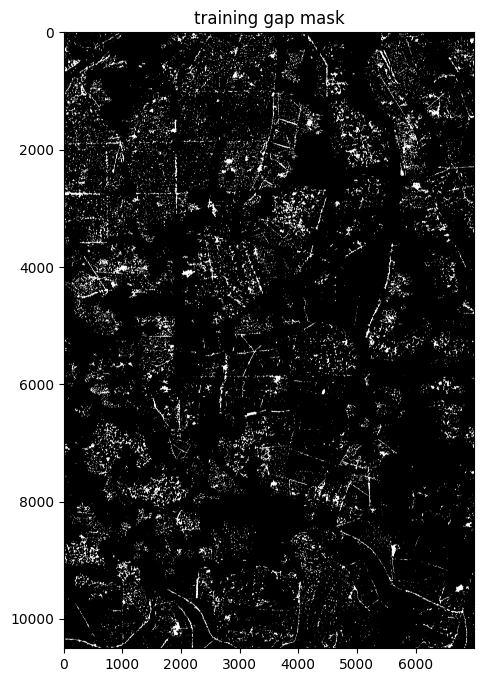

In [11]:
# plot the train gap mask
fig, ax = plt.subplots(figsize=(14,8))
ax.imshow(train_ds.gap_mask, cmap='gray')
ax.set_title('training gap mask')
plt.show()

### 3.3 rename spectral bands in the dataset and save it to disk

In [12]:
# rename spectral bands
new_variable_names = {'band_1': 'red', 'band_2': 'green', 'band_3': 'blue', 'band_4': 'nir'}
train_ds = train_ds.rename(new_variable_names)

# dictionary mapping new variable names to their long names
long_names = {
    'red'  : 'red',
    'green': 'green',
    'blue' : 'blue',
    'nir'  : 'nir',
    'ndsm' : 'ndsm'
}

# function to update the long_name attribute
def update_long_names(dataset, long_name_mapping):
    for var_name, long_name in long_name_mapping.items():
        if var_name in dataset:
            dataset[var_name].attrs['long_name'] = long_name

# update long_name in the dataset
update_long_names(train_ds, long_names)

In [15]:
# save final dataset to disk
#-----------------------------
# define path to final dataset files
# (as tif and csv)
train_ds_tif_file = processed_data_dir / 'datasets' / 'train_ds.tif'
train_ds_csv_file = processed_data_dir / 'datasets' / 'train_ds.csv'

# check if final dataset already exists
if not train_ds_tif_file.exists() or not train_ds_csv_file.exists():
    
    # save dataset 
    # as tif
    train_ds.rio.to_raster(train_ds_tif_file)
    # as csv
    df_train = train_ds.to_dataframe()
    df_train.to_csv(train_ds_csv_file)
    
    print('Train dataset saved.')
    
else:
    
    # load existing dataset
    train_ds = rxr.open_rasterio(train_ds_tif_file, band_as_variable=True)

    # use the long_names as variable names 
    for var_name in train_ds.data_vars:
        long_name = train_ds[var_name].attrs['long_name']
        train_ds = train_ds.rename({var_name: long_name})
        
    print('Existing train dataset loaded.')

Train dataset saved.


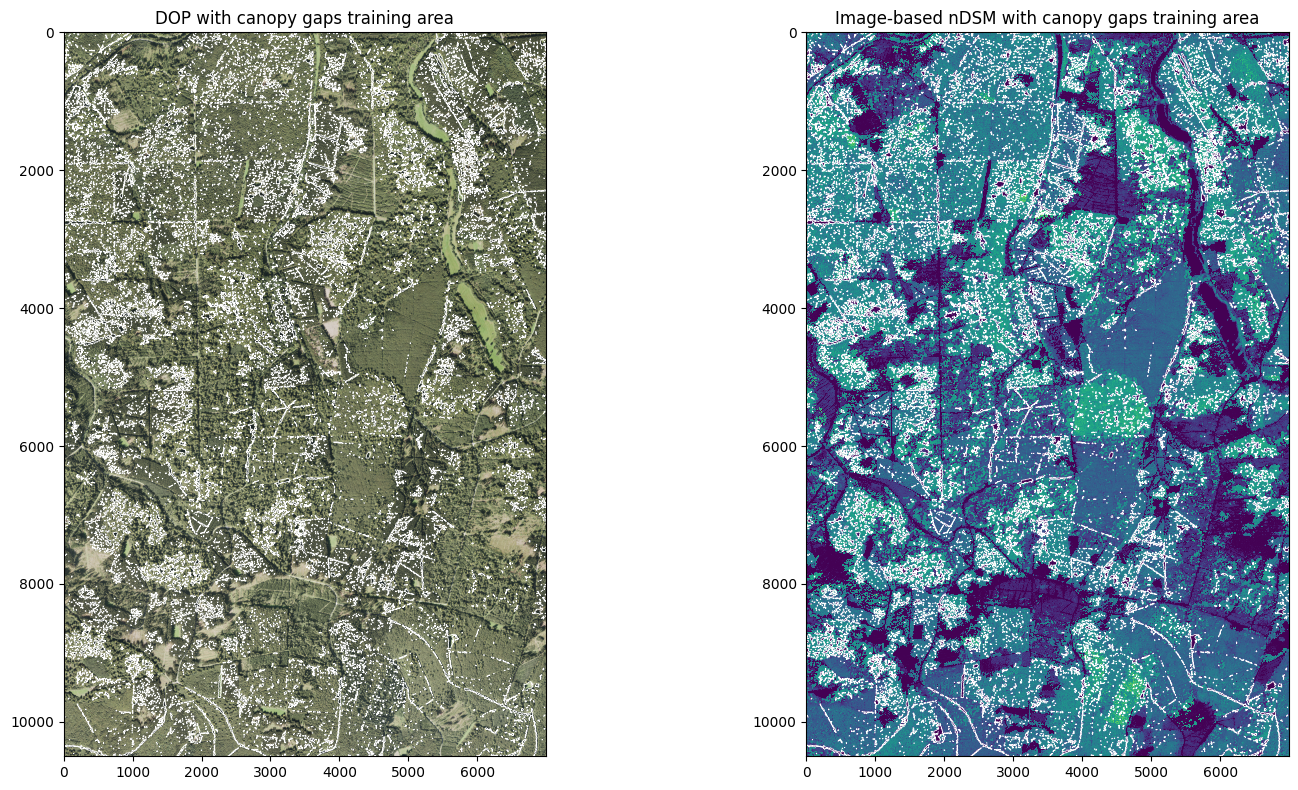

In [17]:
# final plot
#------------

# normalize RGB bands to [0, 1] range
train_rgb_norm = np.stack([train_ds.red, train_ds.green, train_ds.blue]).transpose(1,2,0)
train_rgb_norm = (train_rgb_norm - train_rgb_norm.min()) / (train_rgb_norm.max() - train_rgb_norm.min())

# plot RGB-DOP and nDSM with gap mask training area
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].imshow(train_rgb_norm)
ax[0].contour(train_ds.gap_mask, levels=[0], colors='white', linewidths=0.5, linestyles='solid')
ax[0].set_title('DOP with canopy gaps training area')
ax[1].imshow(train_ds.ndsm, cmap='viridis', interpolation='none')
ax[1].contour(train_ds.gap_mask, levels=[0], colors='white', linewidths=0.5, linestyles='solid')
ax[1].set_title('Image-based nDSM with canopy gaps training area')
plt.tight_layout()
plt.show()